<a href="https://colab.research.google.com/github/cflores23/optimizacion/blob/main/nonlinear_regression_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import copy    # array-copying convenience
import sys     # max float
import random
import pandas as pd

Leemos el dataset y se explora un poco para ver que datos trae

In [2]:
data = pd.read_csv('covid_mex.csv')
data.tail

<bound method NDFrame.tail of            date  total_cases  total_deaths
0     2/28/2020            1             0
1     2/29/2020            4             0
2      03/01/20            5             0
3      03/02/20            5             0
4      03/03/20            5             0
..          ...          ...           ...
668  12/27/2021      3951003        298777
669  12/28/2021      3951946        298819
670  12/29/2021      3956372        298944
671  12/30/2021      3961662        299132
672  12/31/2021      3979723        299428

[673 rows x 3 columns]>

In [3]:
maxs = data.max()

print("Max of Each Column:")
print(maxs)

Max of Each Column:
date            9/30/2021
total_cases       3979723
total_deaths       299428
dtype: object


Graficando los datos del dataset, con el objetivo de tener un panorama general de la tendencia que siguen:

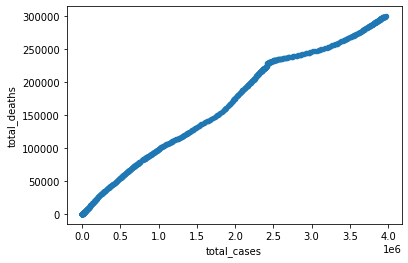

In [4]:
graf=data.plot("total_cases","total_deaths", kind="scatter")
plt.show()

La regresión no lineal trata de ajustar una función no lineal a un conjunto de puntos. En otras palabras, se desea encontrar los parámetros de la siguiente función []:

$y = f(x,θ)+ϵ$

Donde $ϵ$ es un término de error

En el problema de regresión se requiere encontrar los valores de los parámetros $θ = (θ_1, θ_2,...,θ_n)$ tal que minimice el criterio de mínimos cuadrados, el cual mide la calidad de la
aproximación funcional propuesta mediante la minimización de la suma de
las diferencias cuadráticas []: 

$S(θ)=∑_{i=1}^{n}[y_i - f(θ_i)]^2$

Por lo tanto se trata de un problema de optimización, donde se debe encontrar el conjunto de valores de los parámetros $θ$ que minimice la suma de los cuadrados de los errores.

En la presente implementación se decide usar un método de búsqueda global basada en población, se usará PSO para encontrar los valores de los parámetros tal como se describe en []. Por lo tanto, esta será la función objetivo.

Se inicia la implementación de la función fitness:

In [5]:
def fitness_square(x, y, position):
  f = 0.0
  fitness_val = 0.0
  for i in range(len(y)):
    #print(i)
    for j in range(len(position)):
      x_i = x[i]
      #print('x_i= '+str(x_i))
      theta_i = position[j]
      f = theta_i*x_i
      #print('f= '+str(f))
      #print('y= '+str(y[i]))
    fitness_val += (y[i] - f)**2
    #print('fit= '+str(fitness_val))

  return fitness_val

In [6]:
#Se crea la clase Partícula
#Cada partícula tiene como atributos: Particle.position (su posición)
                                    # Particle.velocity (su velocidad)
                                    # Particle.fitness (su valor de aptitud)
                                    # Particle.bestPos (la posición de la mejor partícula)
                                    # Particle.bestFitness (la aptitud de la partícula con mejor posición)
class Particle:
  def __init__(self, fitness, dim, minx, maxx, semilla, x, y):
    self.rnd = random.Random(semilla)

    # Se inicializa la posición de la partícula en 0.0
    self.position = [0.0 for i in range(dim)]
 
     # Se inicializa el valor de la velocidad de la partícula con 0.0
    self.velocity = [0.0 for i in range(dim)]
 
    # Se inicializa la mejor posición de la partícula con 0.0
    self.best_part_pos = [0.0 for i in range(dim)]
 
    # Repetir n veces para calcular la posición y la velocidad
    # range of position and velocity is [minx, max]
    for i in range(dim):
      self.position[i] = ((maxx - minx) *
        self.rnd.random() + minx)
      self.velocity[i] = ((maxx - minx) *
        self.rnd.random() + minx)
 
    # calcular el fitness de la partícula
    self.fitness = fitness(x, y, self.position)
 
    # inicializar la mejor posición y fitness de la partícula
    self.best_part_pos = copy.copy(self.position)
    self.best_part_fitnessVal = self.fitness

In [7]:
def pso(fitness, max_iter, n, dim, minx, maxx, x, y):
  # parámetros de PSO
  w = 0.729    # inercia
  c1 = 1.49445 # cognitiva (particula)
  c2 = 1.49445 # social (swarm)
 
  rnd = random.Random(0)
 
  # crear las n partículas
  swarm = [Particle(fitness, dim, minx, maxx, i, x, y) for i in range(n)]
  # calcular el valor de la mejor posición y mejor fitness en todo el swarm
  best_swarm_pos = [0.0 for i in range(dim)]
  # el mejor swarm
  best_swarm_fitnessVal = sys.float_info.max 
 
  # calcular la mejor particula del swarm y su respectivo fitness
  for i in range(n): 
    if swarm[i].fitness < best_swarm_fitnessVal:
      best_swarm_fitnessVal = swarm[i].fitness
      best_swarm_pos = copy.copy(swarm[i].position)
 
  # Inicia el algoritmo PSO
  Iter = 0
  while Iter < max_iter:
     
    # Imprimir los resultados parciales, cada 10 iteraciones
    if Iter % 10 == 0 and Iter > 1:
      print("Iterción = " + str(Iter) + " mejor fitness = %.3f" % best_swarm_fitnessVal)
 
    for i in range(n): 
       
      # Calcular la nueva velocidad de la partícula actual
      for k in range(dim):
        r1 = rnd.random()    
        r2 = rnd.random()
     
        swarm[i].velocity[k] = (
                                 (w * swarm[i].velocity[k]) +
                                 (c1 * r1 * (swarm[i].best_part_pos[k] - swarm[i].position[k])) + 
                                 (c2 * r2 * (best_swarm_pos[k] -swarm[i].position[k]))
                               ) 
 
 
        # Se comprueba si la velocidad está dentro del rango
        #Si no entonces la regresamos dentro del límite permitido
        if swarm[i].velocity[k] < minx:
          swarm[i].velocity[k] = minx
        elif swarm[i].velocity[k] > maxx:
          swarm[i].velocity[k] = maxx
 
 
      # Se calcula la nueva posición, para ello se una la nueva velocidad obtenida
      for k in range(dim):
        swarm[i].position[k] += swarm[i].velocity[k]
   
      # Se calcula la aptitud de la nueva posición
      swarm[i].fitness = fitness(x,y,swarm[i].position)
 
      # Comprobamos si la nueva posición es la mejor de la partícula
      if swarm[i].fitness < swarm[i].best_part_fitnessVal:
        swarm[i].best_part_fitnessVal = swarm[i].fitness
        swarm[i].best_part_pos = copy.copy(swarm[i].position)
 
      # Comprobamos si la nueva posición es la mejor globalmente
      if swarm[i].fitness < best_swarm_fitnessVal:
        best_swarm_fitnessVal = swarm[i].fitness
        best_swarm_pos = copy.copy(swarm[i].position)
     
    Iter += 1

  return best_swarm_pos

In [9]:
print("*****Inicio****\n")
#Para obtener la dim se puede obtener el número de columnas del dataset
#Obvio, una vez realizada la limpieza del mismo
dim = 1
#Este string lo puse para definir la función objetivo, para el caso de que
#sea un problema con restricciones es eficiente este método
fitness = fitness_square
 
 
print("El número de variables predictoras o dimensiones es " + str(dim) + " variables")
for i in range(dim-1):
  print("0, ", end="")
print("0)")
 
num_particles = 500
max_iter = 100

x=data['total_cases'].tolist()
#x = np.array(x)
y=data['total_deaths'].tolist()
#y = np.array(y)
 
print("Número de partículas = " + str(num_particles))
print("Número máximo de iteraciones    = " + str(max_iter))
print("\nIniciando la ejecución del algoritmo\n")
 
 
 
best_position = pso(fitness, max_iter, num_particles, dim, 0.0, 10.0, x, y)
 
print("\nFin de la ejecución\n")
print("\nMejor solución encontrada:")
print(["%.6f"%best_position[k] for k in range(dim)])
fitnessVal = fitness(x, y, best_position)
print("Valor de aptitud de la mejor solución = %.6f" % fitnessVal)
 
 

*****Inicio****

El número de variables predictoras o dimensiones es 1 variables
0)
Número de partículas = 500
Número máximo de iteraciones    = 100

Iniciando la ejecución del algoritmo

Iterción = 10 mejor fitness = 258359703722.907
Iterción = 20 mejor fitness = 258359703722.907
Iterción = 30 mejor fitness = 258359703722.907
Iterción = 40 mejor fitness = 258359703722.907
Iterción = 50 mejor fitness = 258359703722.907
Iterción = 60 mejor fitness = 258359703722.907
Iterción = 70 mejor fitness = 258359703722.907
Iterción = 80 mejor fitness = 258359703722.907
Iterción = 90 mejor fitness = 258359703722.907

Fin de la ejecución


Mejor solución encontrada:
['0.086478']
Valor de aptitud de la mejor solución = 258359703722.906982


Una vez que se ha obtenido la mejor solución del swarm se puede usar para predecir. En nuestro caso, como se trata de un dataset con datos del número de casos confirmados de covid en México desde el inicio de la pandemia hasta el último día del año 2021, vamos a predecir, cuantas muertes podría haber si el número de contagios incrementa a 6,000,000. Para este ejemplo no se toma en cuenta otras variables, como por ejemplo el número de personas vacunadas, que podría repercutir en esta predicción.

In [10]:
y=0.086478*6000000
y

518868.0

In [11]:
def f(r, best_p):
  y = r*best_p
  return y

Tal como se puede apreciar, para este caso, como solo se considera una variable predictora, el resultado es una simple regresión lineal. Por lo que la gráfica de ajuste a los datos es tal como se ve en la siguiente figura:

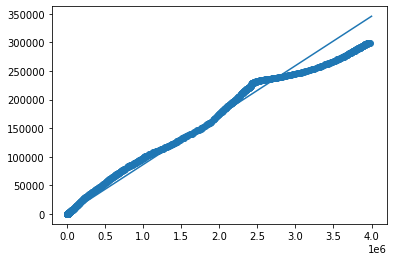

In [12]:
x_s=range(0,4000000)
best = [best_position[k] for k in range(dim)]
fig, ax = plt.subplots()
ax.scatter(data['total_cases'],data['total_deaths'])
ax.plot(x_s,[f(i,best[0]) for i in x_s])
plt.show()

No considerar las siguientes celdas.

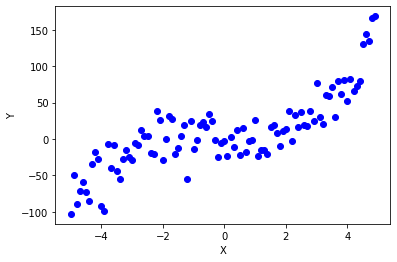

In [ ]:
#Generamos un conjunto de datos aleatorios con cierto ruido para que tengan cierta separación
min_x = -5.0
max_x = 5.0
x = np.arange(min_x, max_x, 0.1)
y = 1*(x**3) + 1*(x**2) + 1*x + 3
y_noise = 20 * np.random.normal(size=x.size)
ydata = y + y_noise
plt.plot(x, ydata,  'bo')
plt.ylabel('Y')
plt.xlabel('X')
plt.show()

In [ ]:
y

array([-1.02000e+02, -9.55390e+01, -8.93520e+01, -8.34330e+01,
       -7.77760e+01, -7.23750e+01, -6.72240e+01, -6.23170e+01,
       -5.76480e+01, -5.32110e+01, -4.90000e+01, -4.50090e+01,
       -4.12320e+01, -3.76630e+01, -3.42960e+01, -3.11250e+01,
       -2.81440e+01, -2.53470e+01, -2.27280e+01, -2.02810e+01,
       -1.80000e+01, -1.58790e+01, -1.39120e+01, -1.20930e+01,
       -1.04160e+01, -8.87500e+00, -7.46400e+00, -6.17700e+00,
       -5.00800e+00, -3.95100e+00, -3.00000e+00, -2.14900e+00,
       -1.39200e+00, -7.23000e-01, -1.36000e-01,  3.75000e-01,
        8.16000e-01,  1.19300e+00,  1.51200e+00,  1.77900e+00,
        2.00000e+00,  2.18100e+00,  2.32800e+00,  2.44700e+00,
        2.54400e+00,  2.62500e+00,  2.69600e+00,  2.76300e+00,
        2.83200e+00,  2.90900e+00,  3.00000e+00,  3.11100e+00,
        3.24800e+00,  3.41700e+00,  3.62400e+00,  3.87500e+00,
        4.17600e+00,  4.53300e+00,  4.95200e+00,  5.43900e+00,
        6.00000e+00,  6.64100e+00,  7.36800e+00,  8.187

In [ ]:
x

array([-5.00000000e+00, -4.90000000e+00, -4.80000000e+00, -4.70000000e+00,
       -4.60000000e+00, -4.50000000e+00, -4.40000000e+00, -4.30000000e+00,
       -4.20000000e+00, -4.10000000e+00, -4.00000000e+00, -3.90000000e+00,
       -3.80000000e+00, -3.70000000e+00, -3.60000000e+00, -3.50000000e+00,
       -3.40000000e+00, -3.30000000e+00, -3.20000000e+00, -3.10000000e+00,
       -3.00000000e+00, -2.90000000e+00, -2.80000000e+00, -2.70000000e+00,
       -2.60000000e+00, -2.50000000e+00, -2.40000000e+00, -2.30000000e+00,
       -2.20000000e+00, -2.10000000e+00, -2.00000000e+00, -1.90000000e+00,
       -1.80000000e+00, -1.70000000e+00, -1.60000000e+00, -1.50000000e+00,
       -1.40000000e+00, -1.30000000e+00, -1.20000000e+00, -1.10000000e+00,
       -1.00000000e+00, -9.00000000e-01, -8.00000000e-01, -7.00000000e-01,
       -6.00000000e-01, -5.00000000e-01, -4.00000000e-01, -3.00000000e-01,
       -2.00000000e-01, -1.00000000e-01, -1.77635684e-14,  1.00000000e-01,
        2.00000000e-01,  